In [34]:
import glob
import numpy as np
import os.path
from ecell4 import *
import math
from math import sqrt,pi
import matplotlib.pyplot as plt
import mpmath as mp
%matplotlib inline
from scipy import special
from mpmath import ellipk
mydehoog = mp.calculus.inverselaplace.deHoog(mp)

def calk(stsim,t,C): #get kt from st
    dst = (stsim[2:]-stsim[:-2])/(t[2:]-t[:-2])
    dst=np.append((stsim[1]-stsim[0])/(t[1]-t[0]),dst)
    dst=np.append(dst,(stsim[-1]-stsim[-2])/(t[-1]-t[-2])  )
    return -dst/stsim/C

def calchange(stsim):
    dst = (stsim[2:]-stsim[:-2])
    dst=np.append((stsim[1]-stsim[0]),dst)
    dst=np.append(dst,(stsim[-1]-stsim[-2]) )
    return -dst

def funclt(t,C1,C2,D): #continuum kt at long time
    #C1=ka,C2=R=2*rm,
    g = 0.577216
    b1=4*D/C2/C2
    A=np.log(b1*t)+4*pi*D/C1-2*g
    return 4*pi*D*(1/A-g/A**2+(g**2-np.pi**2/6)/A**3+0.25/A**4)

def funcL(t,P,l,D,Ns,Area):    
    g = 0.577216
    td=l*l/4/D
    kap=P*Area/td/Ns
    b1=48*D/l/l
    a = 2*pi/sqrt(3)
    A=np.log(b1*t)+a*(1./P-1)
    return a*kap*(1/A-g/A**2+(g**2-np.pi**2/6)/A**3+0.25/A**4)/P

def latK(s,D,Pa,td):
    b1 = Pa/6/td;
    b2 = 1/td;
    p101 = 1/6; 
    zz = b2/(b2+s);
    a = 3/zz+1-(3+6/zz)**0.5;
    b = 3/zz+1+(3+6/zz)**0.5;
    c = (a+1)*(b-1);
    kk = 2*(b-a)/c
    EF = ellipk(kk);
    Pz = 6*EF/pi/zz/(c)**0.5;
    f11 = 1-zz*zz*p101/(Pz-1);
    g = b1/(s+b1+b2-s*zz/3-b2*f11);
    return 2*Pa*D*3**0.5*(1-g)/s;

def invltL(t,D,Pa,td): #inverse laplace transform of lattice k(s)
    mp.dps = 8#15;
    t = mp.convert(t)
    mydehoog.calc_laplace_parameter(t)
    fpvec = [latK(p,D,Pa,td) for p in mydehoog.p]
    ft =(float(mydehoog.calc_time_domain_solution(fpvec,t,manual_prec=True)))
    return ft

/home/chew/outputdata/keff/2D/newkfac0.01_N423_L6.5_50tm_1.0208582rm/*
size 40000
0.11534917219058866 0.11591655150096743


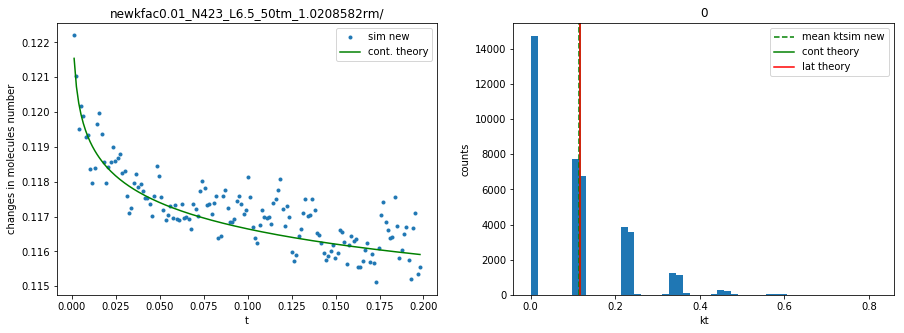

In [41]:
kf=0.01
g = 0.577216
L=6.5
f=1.0208582
N0=423
Area = 42.3799
R=0.01
D=1
ka=kf*D*4*pi
l=R*f
w = spatiocyte.SpatiocyteWorld(Real3(0.1*L,L,L),l*0.5)
size=tuple(w.calculate_shape(Real3(0.1*L,L,L),l*0.5))
Ns=size[1]*size[2]
P=1./(1+math.sqrt(3)*(math.log(f*f/12)+(4*math.pi*D/ka)-2*g)/2/math.pi)

#fig,ax=plt.subplots(4,1,figsize=(7,20))
fig,ax=plt.subplots(1,2,figsize=(15,5))
clr=['g','m']
for i,pad in enumerate(['new']):#,'new']):
    #pattern = '/home/chew/spatiocyte_example/2D/output/{}Pa_2D_irr_kf{}N{}L6.5/*'.format(pad,kf,N0)
    pattern = '/home/chew/outputdata/keff/2D/{}kfac{}_N{}_L{}_50tm_1.0208582rm/*'.format(pad,kf,N0,L)
    FNS = glob.glob(pattern)[:40000]
    print(pattern)
    print('size',len(FNS))
    ss=[]
    cnter = 0
    #ktlast=[[],[],[]]
    ktlast=[]
    KT=[]
    tlast=[]
    dur = 0.2
    CC=[]
    cclast=[]
    ST=[]
    for fn in FNS:
        #t,nt=np.array(np.loadtxt(fn,delimiter=',',skiprows=1)).T
        t,nt=np.loadtxt(fn,delimiter=',').T
        assert(nt[0]==N0)
        ds=1
        nt=nt[1::ds]
        t=t[1::ds]
        idx = t<dur
        t=t[idx]
        nt=nt[idx]
        st =nt/float(N0)
        kt = calk(st,t,N0/Area)[:-1]
        cc = calchange(nt)[:-1]
        t=t[:-1]
        #ktlast[0].append(kt[-1])
        ktlast.append(kt[-2])  
        cclast.append(cc[-2])
        
        #ktlast[2].append(kt[-3])    
        cnter+=1
        if len(KT)==0:
            KT = kt
            CC = cc
            ST=st
        else: 
            KT+=kt    
            CC+=cc
            ST+=st
    tlast=t[-2]
    KT = KT/cnter
    CC = CC/cnter
    ST=ST/cnter
    
    dt=t[2]-t[0]
    CCT = funcL(t,P,l,D,Ns,Area)*dt*ST[:-1]*N0*N0/Area
    #ax[0].plot(t,CC,'.')
    #ax[0].plot(t,CCT,'-')
    ax[0].plot(t,KT,'.',label='sim '+pad)
    ax[0].plot(t,funclt(t,ka,R,D),'g-',label='cont. theory')
    #ax[0].plot(t,funcL(t,P,l,D,Ns,Area),'r-',label='lat theory')       
    j=0
    ktl = ktlast
    tl=tlast
    #int(len(FNS)/20)
    plt.hist(ktl,bins=50)
    #cnt,bn = np.histogram(ktl,bins=50,normed=True)#,color=clr[i],alpha=0.5,label='ktsim '+pad)
    #mdpnt = (bn[1:]+bn[:-1])*0.5
    #mdpnt = mdpnt[cnt!=0]
    #cnt = cnt[cnt!=0]        
    #ax[j+1].plot(mdpnt,cnt,'-',color=clr[i],alpha=0.5,label='ktsim '+pad)
    ax[j+1].set_title(str(j))
    mn=np.mean(ktl)
    print(mn,funcL(tl,P,l,D,Ns,Area))
    ax[j+1].axvline(mn,color=clr[i],linestyle='--',label='mean ktsim '+pad)
    ax[j+1].axvline(funclt(tl,ka,R,D),c='g',label='cont theory')   
    ax[j+1].axvline(funcL(tl,P,l,D,Ns,Area),c='r',label='lat theory')
    ax[j+1].set_xlabel('kt')
    ax[j+1].set_ylabel('counts')    
    #ax[j+1].set_xlim(0.11,0.12)
    ax[j+1].legend()        
    
    ax[0].set_title(pattern[30:-1])
    ax[0].set_ylabel('changes in molecules number')
    ax[0].set_xlabel('t')
    ax[0].legend()    
    

(0.115, 0.122)

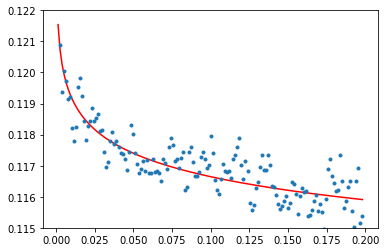

In [43]:
C=N0/Area
ktm=CCT/N0/dt/ST[:-1]/C
ktm2=CC/N0/dt/ST[:-1]/C
#plt.plot(t,ktm,'.')
plt.plot(t,funclt(t,ka,R,D),'r-',label='lat theory')       
plt.plot(t,ktm2,'.')
plt.ylim(0.115,0.122)

In [3]:
kf=0.01
g = 0.577216
L=6.5
f=1.0208582
N0=423
Area = 42.3799
R=0.01
D=1
ka=kf*D*4*pi
l=R*f
w = spatiocyte.SpatiocyteWorld(Real3(0.1*L,L,L),l*0.5)
size=tuple(w.calculate_shape(Real3(0.1*L,L,L),l*0.5))
print(size)
Ns=size[1]*size[2]
P=1./(1+math.sqrt(3)*(math.log(f*f/12)+(4*math.pi*D/ka)-2*g)/2/math.pi)
print(Ns)
T=np.linspace(0.005,0.2,30)
ktL = np.array([invltL(t,D,P,td) for t in T])
plt.title('kf={},D={},R={}'.format(kf,D,R))
plt.plot(T,ktL,'-',label='lattice theory exact DL')
plt.plot(T,funclt(T,ka,R,D),'g-',label='long time cont. theory')
plt.plot(T,funcL(T,P,l,D,Ns,Area),'r--',label='long time lat theory')
plt.ylim(0.114,0.123)
plt.legend()

(80, 638, 736)
469568


NameError: name 'td' is not defined

In [6]:
Ns=1./(100./469568)

In [7]:
sqrt(6*l*l*Ns/4/sqrt(3))

0.6509984941118276

In [45]:
100-96.278314

3.7216860000000054

In [51]:
100-96.332112

3.667888000000005

In [67]:
1-100/2688

0.9627976190476191

In [69]:
(1-2.84033278926426e-07*3443005.00169381)*2688

59.329536023714226

In [71]:
100-99.978548

0.021451999999996474

In [81]:
10*10/2688/2.84033e-07

130979.0797279927

In [84]:
1/4970/5.68067e-07,

(354.1963244841975,)

expected=10*10/2688/2.84033e-07=130979.0797279927
Da0,Db1
t=0.199959231999984,130549.611232764
Da1,Db0
t=0.199959231999984,128534.800533751
Da0.5,Db0.5
t=0.199959231999984,126135.611483055

In [85]:
1/4940/2.84033e-07,sim=711,711

712.6958832162842

In [ ]:
expected=712.6958832162842
simulation=712.184,714.291